In [112]:
import logging
import os
import sys
import warnings
import shutil
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn
import scipy.stats as sc_sts
import mlxtend

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

%matplotlib inline

In [2]:
## Some display settings
pd.set_option('display.max_rows',105)
pd.set_option('display.max_columns',50)
warnings.filterwarnings(category=FutureWarning,action='ignore')

In [3]:
## Visualization Global Variables
label_dict = {'family':'Calibri','size':21,'style':'oblique','color':'coral'}
title_dict = {'family':'Calibri','size':23,'style':'oblique','color':'magenta'}
wedge_dict = {'linewidth': 1, 'edgecolor': 'black'}
txt_dict = {'family':'Calibri','size':16,'style':'oblique','color':'k'}

In [4]:
cer_cancer_df = pd.read_csv("CC_Before_train_test_split.csv")

In [4]:
# cer_cancer_df = pd.read_csv('Datasets/Cervical_cancer/kag_risk_factors_cervical_cancer.csv').rename(columns={'Citology':'Cytology'})

In [5]:
# cer_cancer_df['Updt_Dx'] = cer_cancer_df[['Dx:Cancer','Dx']].apply(lambda row: 1 if row['Dx:Cancer'] == 1 and row['Dx'] == 0 else row['Dx'],\
#                                                                    axis=1)

In [6]:
# cer_cancer_df.drop(['STDs: Number of diagnosis',
#        'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
#        'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx'],axis=1,inplace=True)

In [7]:
# cer_cancer_df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'Hinselmann', 'Schiller', 'Cytology',
       'Biopsy', 'Updt_Dx'],
      dtype='object')

#### **Filling missing values**
- *'Hormonal Contraceptives'*
- *'Hormonal Contraceptives (years)'*
- *'IUD'*
- *'IUD (years)'*
- *'STDs'*
- *'STDs (number)'*
- *'STDs:condylomatosis'*
- *'STDs:cervical condylomatosis'*
- *'STDs:vaginal condylomatosis'*
- *'STDs:vulvo-perineal condylomatosis'*
- *'STDs:syphilis'*
- *'STDs:pelvic inflammatory disease'*
- *'STDs:genital herpes'*
- *'STDs:molluscum contagiosum'*
- *'STDs:AIDS'*
- *'STDs:HIV'*
- *'STDs:Hepatitis B'*
- *'STDs:HPV'*

#### **For the above columns if 'Hormonal Contraceptives','STDs', 'IUD' and their corresponding features containing missing values then they all are imputed as -1.**
- The reason for imputing -1 is that these features are important in terms of prediction thus if patient doesn't provide these details then not even the doctor can tell whether the patient is positive or not in the screening. Hence, I thought this would be best way to make the model learn such kind of data with a different manner.
    - I'm applying this implementation on the entire dataset then will create a separate TRAIN and TEST splits. This will introduce any data leakage as I'm filling an all together different value irrespective of the dataset. And, this has be to be implemented in the both the sets.

In [5]:
cer_cancer_df[['Hormonal Contraceptives','STDs','IUD','STDs:cervical condylomatosis']].\
apply(lambda row: -1 if row['STDs']=='?' and row['Hormonal Contraceptives']=='?' and row['IUD']=='?' else row['STDs:cervical condylomatosis']\
      ,axis=1).value_counts()

0.0    753
-1      95
?       10
dtype: int64

In [72]:
# cer_cancer_df['STDs:cervical condylomatosis'] = cer_cancer_df[['Hormonal Contraceptives','STDs','IUD','STDs:cervical condylomatosis']].\
# apply(lambda row: -1 if row['STDs']==-1 and row['Hormonal Contraceptives']==-1 and row['IUD']==-1 else row['STDs:cervical condylomatosis']\
#      ,axis=1)

##### **I have performed the above implementation manually, later on will create a function of it.**

In [18]:
def compute_null_percentage(data_df,missing_type):
    """
    Description: This function is created for calculating the NULL values percentage in every feature.
    
    Input: It accepts below parameters:
        - `data_df: pandas dataframe`
                Dataframe with entire dataset
    
    Return: It returns below object:
        -  `nulls_info_df: pandas dataframe`
                Dataframe containing nulls percentage feature-wise.    
    """
    cols = []
    null_percentage = []

    for col in data_df.columns:
        if missing_type == '?':
            no_of_nulls = data_df[data_df[col] == '?'].shape[0]
        else:
            no_of_nulls = data_df[data_df[col].isna()].shape[0]
        tot_rec = data_df.shape[0]
        nulls_percent = np.round((np.divide(no_of_nulls,tot_rec,dtype= np.float) * 100),2)
        cols.append(col)
        null_percentage.append(nulls_percent)
    
    nulls_info_df = pd.DataFrame({'Feature_Name':cols,'NULL Percentage':null_percentage})
    return nulls_info_df

In [19]:
nulls_percentage_df = compute_null_percentage(data_df=cer_cancer_df,missing_type='?')

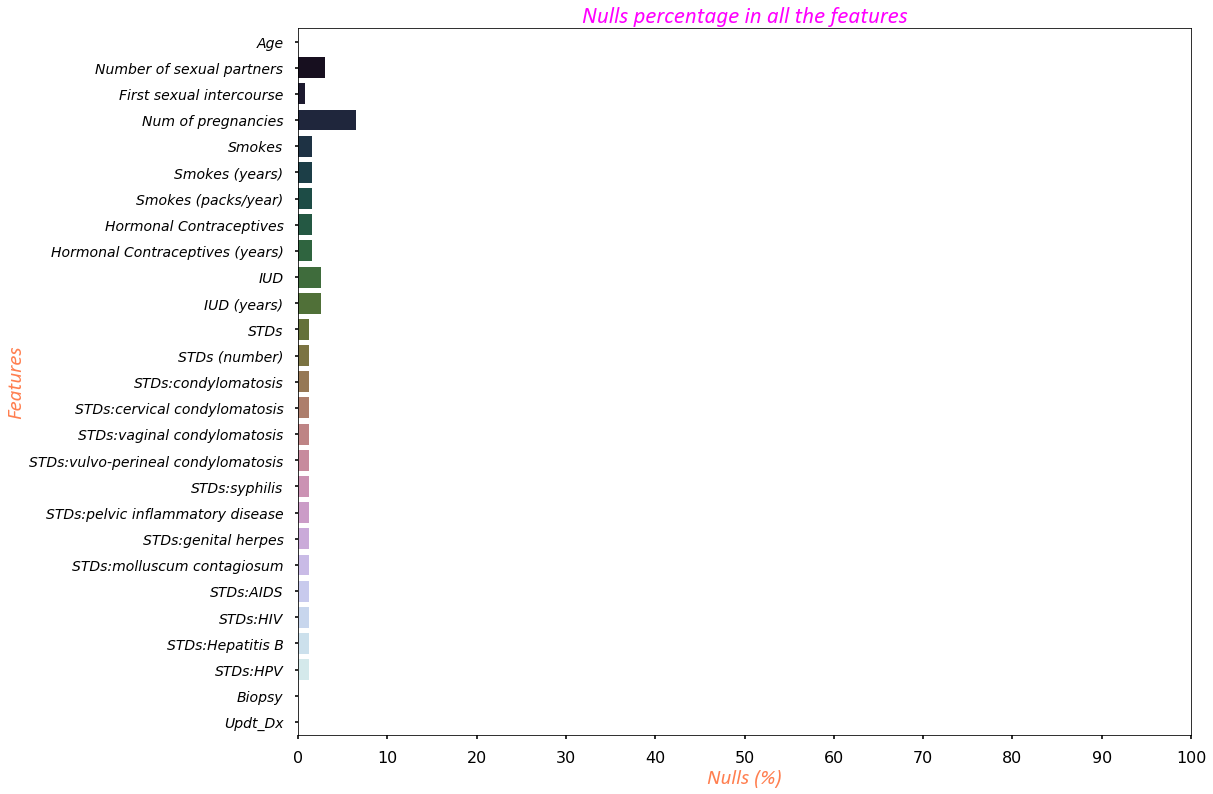

In [20]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(16,13))
    sns.barplot(y='Feature_Name',x='NULL Percentage',data=nulls_percentage_df,palette='cubehelix')
    plt.xlabel('Nulls (%)',fontdict=label_dict)
    plt.ylabel('Features',fontdict=label_dict)
    plt.title('Nulls percentage in all the features',fontdict=title_dict)
    plt.xticks(np.arange(0,101,10))
    plt.yticks(size=14,rotation=0,style='italic',color='k')

### ***`First, I'm taking trying to build a model that can predict whether patient should undergo Biopsy or not?`***

In [83]:
# cer_cancer_df.drop(['Hinselmann', 'Schiller', 'Cytology'],axis=1,inplace=True)

In [10]:
# cer_cancer_df.to_csv('CC_Before_train_test_split.csv',index=False)

In [13]:
# cer_cancer_df = pd.read_csv("CC_Before_train_test_split.csv")

In [8]:
cer_cancer_df['Biopsy'].value_counts()

0    803
1     55
Name: Biopsy, dtype: int64

In [9]:
X = cer_cancer_df[['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV','Updt_Dx']]

X.shape

(858, 26)

In [10]:
y = cer_cancer_df[['Biopsy']]

y.shape

(858, 1)

#### **Separating data into TRAIN and TEST sets**

In [11]:
X1, X_test, y1, y_test = train_test_split(X,y,test_size=0.40,stratify=y,random_state=24)

In [12]:
print(X1.shape,y1.shape,X_test.shape,y_test.shape)

(514, 26) (514, 1) (344, 26) (344, 1)


In [13]:
y1.value_counts()

Biopsy
0         481
1          33
dtype: int64

In [14]:
y_test.value_counts()

Biopsy
0         322
1          22
dtype: int64

### **Checking whether TRAIN and TEST are from same distribution**
- *This is an important step because if Train and Test doesn't belongs to the same distribution then it means both the datasets are coming from different populations and are totally separable which is not the right thing.*

##### **Dropping the diagnosis feature from both the sets as this column won't be available in real-time**

In [16]:
X1 = X1.drop(['Updt_Dx'],axis=1)
X_test = X_test.drop(['Updt_Dx'],axis=1)

##### **Creating new `train1` and `test1` sets from `TRAIN` and `TEST`**

##### **TRAIN1**

In [15]:
X1 = X1.applymap(lambda val: np.NaN if val =='?' else np.float(val))

In [16]:
X1.shape

(514, 26)

In [17]:
y1.shape

(514, 1)

In [23]:
train1 = pd.concat([X1.iloc[:,:].reset_index(drop=True),y1.iloc[:,:].reset_index(drop=True)],axis=1)

In [24]:
train1['target'] = 1   ## Added a new dummy target with value as 1

In [25]:
train1.shape

(514, 27)

In [26]:
train1.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Biopsy,target
0,25.0,2.0,20.0,1.0,0.0,0.0,0.0,1.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,27.0,6.0,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,27.0,5.0,19.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,39.0,2.0,17.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,24.0,2.0,18.0,1.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


##### **TEST1**

In [28]:
X_test = X_test.applymap(lambda val: np.NaN if val =='?' else np.float(val))

In [29]:
test1 = pd.concat([X_test.reset_index(drop=True),y_test.reset_index(drop=True)],axis=1)

In [30]:
test1['target'] = 0

In [31]:
test1.shape

(344, 27)

In [32]:
test1.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Biopsy,target
0,15.0,4.0,12.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,39.0,1.0,24.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,27.0,1.0,17.0,3.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,32.0,1.0,22.0,2.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,22.0,1.0,16.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


##### **Imputing Missing Values in `train1` and `test1` using KNN Imputer**

In [33]:
knn_imputer = KNNImputer(n_neighbors=7,weights='distance')

In [34]:
train1_missing_removed = pd.DataFrame(knn_imputer.fit_transform(train1),columns=train1.columns)

In [35]:
test1_missing_removed = pd.DataFrame(knn_imputer.fit_transform(test1),columns=test1.columns)

##### **Model training on `train1` and testing on `test1`**

In [36]:
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=7)

In [37]:
dt_model = dt.fit(train1_missing_removed.iloc[:,0:-1],train1_missing_removed['target'])

In [38]:
knn_model = knn.fit(train1_missing_removed.iloc[:,0:-1],train1_missing_removed['target'])

##### **Decision Tree :: Results**

In [39]:
y_pred = dt_model.predict(test1_missing_removed.iloc[:,0:-1])

In [40]:
accuracy_score(y_pred,y_test), precision_score(y_pred,y_test), recall_score(y_pred,y_test)

(0.06395348837209303, 1.0, 0.06395348837209303)

In [41]:
confusion_matrix(y_pred,y_test)

array([[  0,   0],
       [322,  22]], dtype=int64)

In [42]:
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

##### **KNN :: Results**

In [43]:
y_pred_knn = knn_model.predict(test1_missing_removed.iloc[:,0:-1])

In [44]:
accuracy_score(y_pred_knn,y_test['Biopsy']), precision_score(y_pred_knn,y_test['Biopsy']), recall_score(y_pred_knn,y_test['Biopsy'])

(0.06395348837209303, 1.0, 0.06395348837209303)

In [45]:
confusion_matrix(y_pred_knn,y_test)

array([[  0,   0],
       [322,  22]], dtype=int64)

In [46]:
y_pred_knn

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

#### **The above results are saying that both TRAIN and TEST sets are entirely similar and not separable. Thus, we are good to go ahead.**

## **`Filling_Missing_Values`**
##### *Here, I'll work on imputing the missing values in TRAIN set.*

In [22]:
nulls_percentage_df = compute_null_percentage(data_df=X1,missing_type=False)

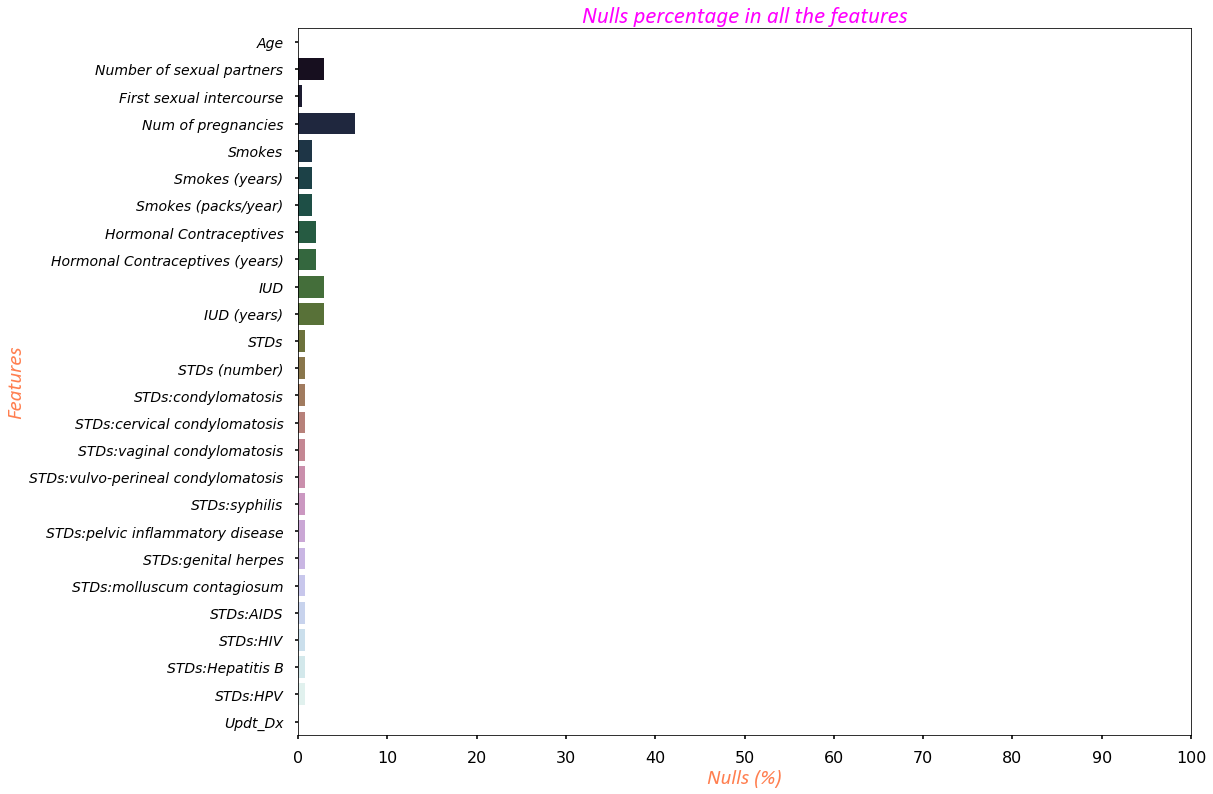

In [23]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(16,13))
    sns.barplot(y='Feature_Name',x='NULL Percentage',data=nulls_percentage_df,palette='cubehelix')
    plt.xlabel('Nulls (%)',fontdict=label_dict)
    plt.ylabel('Features',fontdict=label_dict)
    plt.title('Nulls percentage in all the features',fontdict=title_dict)
    plt.xticks(np.arange(0,101,10))
    plt.yticks(size=14,rotation=0,style='italic',color='k')

##### **Imputing `Number of sexual partners`**

In [24]:
X1_sex_partners_mean = np.round(X1.groupby(['Updt_Dx'])['Number of sexual partners'].mean(),3).to_dict()
X1_sex_partners_mean

{0.0: 2.535, 1.0: 2.895}

In [25]:
X1['Number of sexual partners'] = X1[['Updt_Dx','Number of sexual partners']].apply(lambda row: X1_sex_partners_mean[0]\
                                                  if row['Updt_Dx'] == 0 and pd.isnull(row['Number of sexual partners'])\
                                                  else X1_sex_partners_mean[1]\
                                                  if row['Updt_Dx'] == 1 and pd.isnull(row['Number of sexual partners'])\
                                                  else row['Number of sexual partners'],axis=1)

##### **Imputing `First Sexual Intercourse`**

In [26]:
X1_first_intercourse_mean = np.round((X1.groupby(['Updt_Dx','Number of sexual partners'])['First sexual intercourse'].mean()),3).to_dict()
X1_first_intercourse_mean

{(0.0, 1.0): 17.77,
 (0.0, 2.0): 16.975,
 (0.0, 2.535): 16.5,
 (0.0, 3.0): 17.096,
 (0.0, 4.0): 16.289,
 (0.0, 5.0): 16.842,
 (0.0, 6.0): 16.333,
 (0.0, 7.0): 14.714,
 (0.0, 8.0): 15.0,
 (0.0, 10.0): 16.0,
 (0.0, 15.0): 16.0,
 (0.0, 28.0): 10.0,
 (1.0, 1.0): 18.333,
 (1.0, 2.0): 16.857,
 (1.0, 3.0): 18.5,
 (1.0, 5.0): 17.0,
 (1.0, 6.0): 17.0}

In [27]:
X1['First sexual intercourse'] = X1[['Updt_Dx','Number of sexual partners','First sexual intercourse']]\
.apply(lambda row: X1_first_intercourse_mean[(0,row['Number of sexual partners'])]\
                                                  if row['Updt_Dx'] == 0 and pd.isnull(row['First sexual intercourse'])\
                                                  else X1_sex_partners_mean[(1,row['Number of sexual partners'])]\
                                                  if row['Updt_Dx'] == 1 and pd.isnull(row['First sexual intercourse'])\
                                                  else row['First sexual intercourse'],axis=1)

##### **Imputing `Smokes (packs/year)`**

In [28]:
X1_smokes_packs_year = X1.groupby(['Updt_Dx'])['Smokes (packs/year)'].mean().to_dict()
X1_smokes_packs_year

{0.0: 0.3922189479673511, 1.0: 1.9473684210526316}

In [29]:
X1['Smokes (packs/year)'] = X1[['Updt_Dx','Smokes (packs/year)']].apply(lambda row: X1_smokes_packs_year[row['Updt_Dx']]\
                                                                        if pd.isnull(row['Smokes (packs/year)'])\
                                                                        else row['Smokes (packs/year)'],axis=1)

##### **Imputing `Hormonal Contraceptives (years)`**

In [30]:
X1_HC_year = X1[X1['Hormonal Contraceptives (years)']!= -1].groupby(['Updt_Dx'])['Hormonal Contraceptives (years)'].mean().to_dict()
X1_HC_year

{0.0: 2.188670258831382, 1.0: 3.063529411764706}

In [31]:
X1['Hormonal Contraceptives (years)']=X1[['Updt_Dx','Hormonal Contraceptives (years)']].apply(lambda row: X1_HC_year[row['Updt_Dx']]\
                                                                        if pd.isnull(row['Hormonal Contraceptives (years)'])\
                                                                        else row['Hormonal Contraceptives (years)'],axis=1)

##### **Imputing `IUD (years)`**

In [32]:
X1_IUD_year = X1[X1['IUD (years)']!= -1].groupby(['Updt_Dx'])['IUD (years)'].mean().to_dict()
X1_IUD_year

{0.0: 0.4643867924528302, 1.0: 1.1333333333333333}

In [33]:
X1['IUD (years)']=X1[['Updt_Dx','IUD (years)']].apply(lambda row: X1_IUD_year[row['Updt_Dx']]\
                                                                        if pd.isnull(row['IUD (years)'])\
                                                                        else row['IUD (years)'],axis=1)

##### **Dropping unwanted columns `'Smokes', 'Smokes (years)','Hormonal Contraceptives' & 'IUD'`**

In [34]:
X1.drop(['Smokes', 'Smokes (years)','Hormonal Contraceptives','IUD'],axis=True,inplace=True)

##### **Imputing `STDs :: Features`**

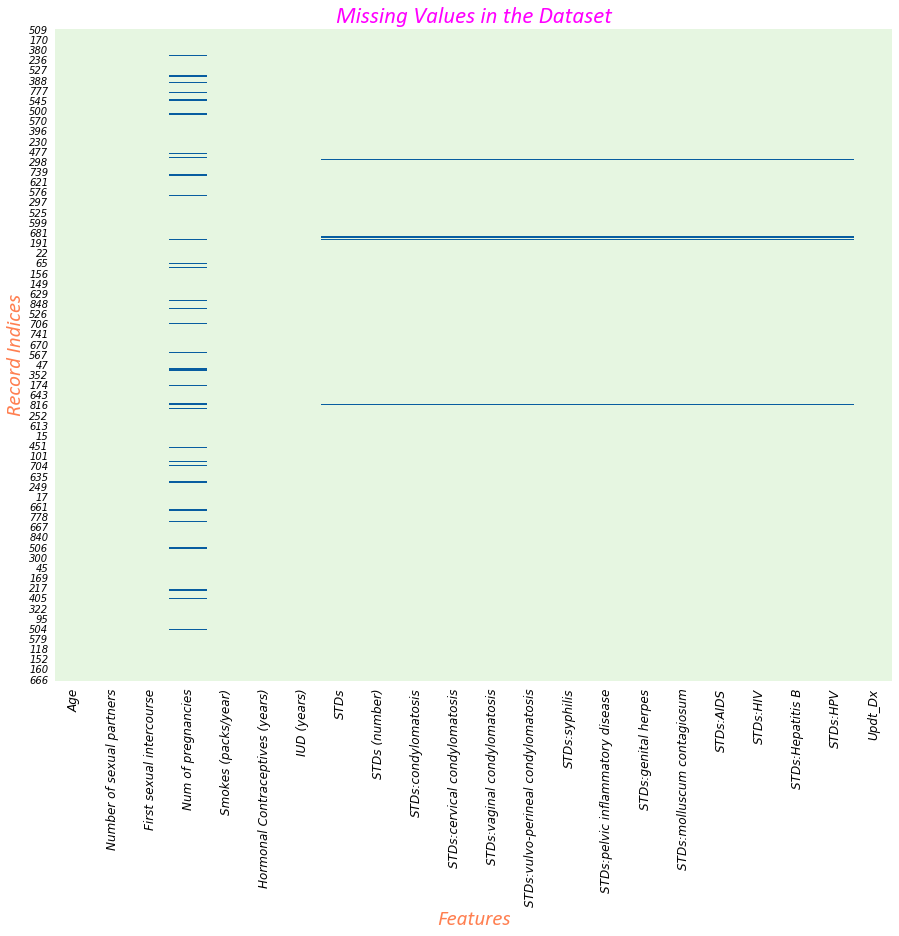

In [36]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,12))
    sns.heatmap(data=pd.DataFrame(X1.isnull()),cmap=ListedColormap(sns.color_palette('GnBu',10)),cbar=False)
    plt.xlabel('Features',fontdict=label_dict)
    plt.ylabel('Record Indices',fontdict=label_dict)
    plt.title('Missing Values in the Dataset',fontdict=title_dict)
    plt.xticks(color='black',size=12,style='oblique')
    plt.yticks(color='black',size=10,style='oblique')
plt.show()

In [37]:
X1[X1['STDs'].isna()]

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Updt_Dx
732,26.0,2.0,17.0,2.0,0.0,0.0,0.464387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
189,25.0,2.0,18.0,2.0,0.0,5.0,0.464387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
807,36.0,2.0,18.0,NaN,7.6,8.0,0.464387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
816,21.0,2.0,19.0,NaN,0.0,0.5,0.464387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [38]:
X1_stds_c = X1[X1['STDs:condylomatosis']!=-1].groupby(['Updt_Dx'])['STDs:condylomatosis'].mean().to_dict()
X1_stds_cc = X1[X1['STDs:cervical condylomatosis']!=-1].groupby(['Updt_Dx'])['STDs:cervical condylomatosis'].mean().to_dict()
X1_stds_vc = X1[X1['STDs:vaginal condylomatosis']!=-1].groupby(['Updt_Dx'])['STDs:vaginal condylomatosis'].mean().to_dict()
X1_stds_vpc = X1[X1['STDs:vulvo-perineal condylomatosis']!=-1].groupby(['Updt_Dx'])['STDs:vulvo-perineal condylomatosis'].mean().to_dict()
X1_stds_syp = X1[X1['STDs:syphilis']!=-1].groupby(['Updt_Dx'])['STDs:syphilis'].mean().to_dict()
X1_stds_pi = X1[X1['STDs:pelvic inflammatory disease']!=-1].groupby(['Updt_Dx'])['STDs:pelvic inflammatory disease'].mean().to_dict()
X1_stds_gh = X1[X1['STDs:genital herpes']!=-1].groupby(['Updt_Dx'])['STDs:genital herpes'].mean().to_dict()
X1_stds_moc = X1[X1['STDs:molluscum contagiosum']!=-1].groupby(['Updt_Dx'])['STDs:molluscum contagiosum'].mean().to_dict()
X1_stds_aids = X1[X1['STDs:AIDS']!=-1].groupby(['Updt_Dx'])['STDs:AIDS'].mean().to_dict()
X1_stds_hiv = X1[X1['STDs:HIV']!=-1].groupby(['Updt_Dx'])['STDs:HIV'].mean().to_dict()
X1_stds_hepb = X1[X1['STDs:Hepatitis B']!=-1].groupby(['Updt_Dx'])['STDs:Hepatitis B'].mean().to_dict()
X1_stds_hpv = X1[X1['STDs:HPV']!=-1].groupby(['Updt_Dx'])['STDs:HPV'].mean().to_dict()

In [39]:
print(X1_stds_c
,X1_stds_cc
,X1_stds_vc
,X1_stds_vpc
,X1_stds_syp
,X1_stds_pi
,X1_stds_gh
,X1_stds_moc
,X1_stds_aids
,X1_stds_hiv
,X1_stds_hepb
,X1_stds_hpv)

{0.0: 0.07175925925925926, 1.0: 0.0} {0.0: 0.0, 1.0: 0.0} {0.0: 0.009259259259259259, 1.0: 0.0} {0.0: 0.06944444444444445, 1.0: 0.0} {0.0: 0.023148148148148147, 1.0: 0.0} {0.0: 0.0023148148148148147, 1.0: 0.0} {0.0: 0.0023148148148148147, 1.0: 0.0} {0.0: 0.0, 1.0: 0.0} {0.0: 0.0, 1.0: 0.0} {0.0: 0.02546296296296296, 1.0: 0.05555555555555555} {0.0: 0.0023148148148148147, 1.0: 0.0} {0.0: 0.0, 1.0: 0.05555555555555555}


In [40]:
X1['STDs:condylomatosis'] = X1[['Updt_Dx','STDs:condylomatosis']].apply(lambda row: X1_stds_c[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:condylomatosis'])\
                                                                        else row['STDs:condylomatosis'],axis=1)

In [41]:
X1['STDs:cervical condylomatosis'] = X1[['Updt_Dx','STDs:cervical condylomatosis']].apply(lambda row: X1_stds_cc[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:cervical condylomatosis'])\
                                                                        else row['STDs:cervical condylomatosis'],axis=1)

In [42]:
X1['STDs:vaginal condylomatosis'] = X1[['Updt_Dx','STDs:vaginal condylomatosis']].apply(lambda row: X1_stds_vc[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:vaginal condylomatosis'])\
                                                                        else row['STDs:vaginal condylomatosis'],axis=1)

In [43]:
X1['STDs:vulvo-perineal condylomatosis']=X1[['Updt_Dx','STDs:vulvo-perineal condylomatosis']].apply(lambda row: X1_stds_vpc[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:vulvo-perineal condylomatosis'])\
                                                                        else row['STDs:vulvo-perineal condylomatosis'],axis=1)

In [44]:
X1['STDs:syphilis'] = X1[['Updt_Dx','STDs:syphilis']].apply(lambda row: X1_stds_syp[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:syphilis'])\
                                                                        else row['STDs:syphilis'],axis=1)

In [45]:
X1['STDs:pelvic inflammatory disease'] = X1[['Updt_Dx','STDs:pelvic inflammatory disease']].apply(lambda row: X1_stds_pi[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:pelvic inflammatory disease'])\
                                                                        else row['STDs:pelvic inflammatory disease'],axis=1)

In [46]:
X1['STDs:genital herpes'] = X1[['Updt_Dx','STDs:genital herpes']].apply(lambda row: X1_stds_gh[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:genital herpes'])\
                                                                        else row['STDs:genital herpes'],axis=1)

In [47]:
X1['STDs:molluscum contagiosum'] = X1[['Updt_Dx','STDs:molluscum contagiosum']].apply(lambda row: X1_stds_moc[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:molluscum contagiosum'])\
                                                                        else row['STDs:molluscum contagiosum'],axis=1)

In [48]:
X1['STDs:AIDS'] = X1[['Updt_Dx','STDs:AIDS']].apply(lambda row: X1_stds_aids[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:AIDS'])\
                                                                        else row['STDs:AIDS'],axis=1)

In [49]:
X1['STDs:HIV'] = X1[['Updt_Dx','STDs:HIV']].apply(lambda row: X1_stds_hiv[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:HIV'])\
                                                                        else row['STDs:HIV'],axis=1)

In [50]:
X1['STDs:Hepatitis B'] = X1[['Updt_Dx','STDs:Hepatitis B']].apply(lambda row: X1_stds_hepb[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:Hepatitis B'])\
                                                                        else row['STDs:Hepatitis B'],axis=1)

In [51]:
X1['STDs:HPV'] = X1[['Updt_Dx','STDs:HPV']].apply(lambda row: X1_stds_hpv[row['Updt_Dx']]\
                                                                        if pd.isnull(row['STDs:HPV'])\
                                                                        else row['STDs:HPV'],axis=1)

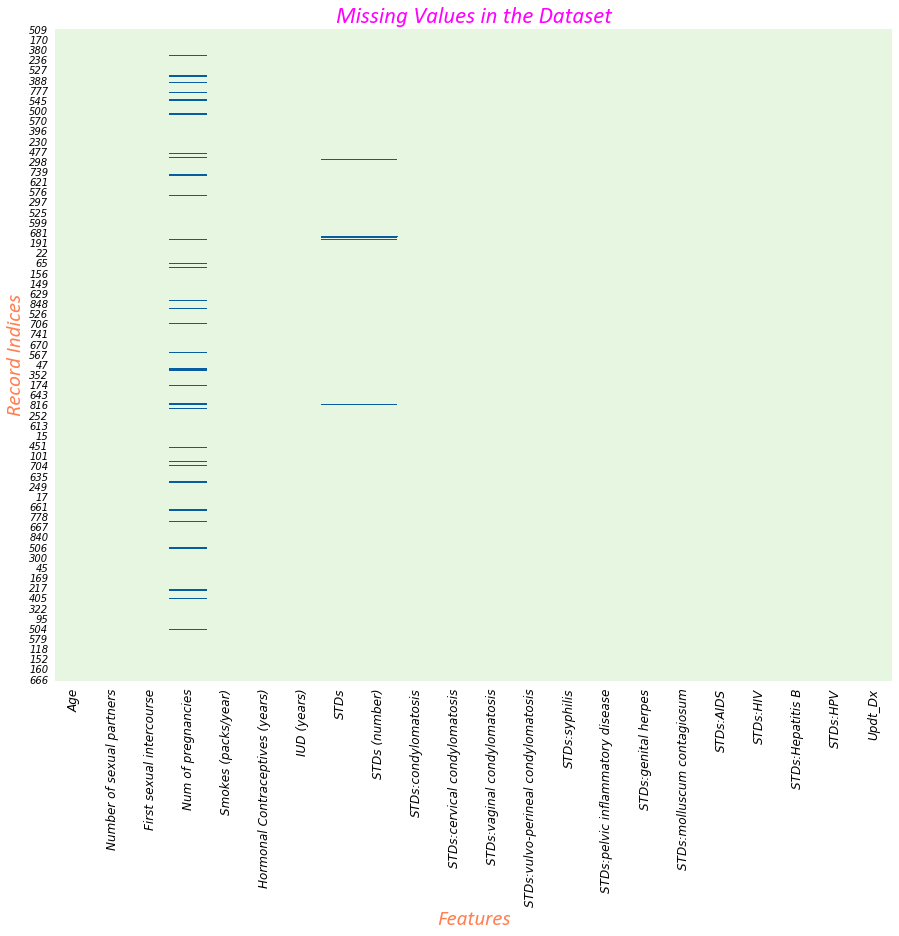

In [52]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,12))
    sns.heatmap(data=pd.DataFrame(X1.isnull()),cmap=ListedColormap(sns.color_palette('GnBu',10)),cbar=False)
    plt.xlabel('Features',fontdict=label_dict)
    plt.ylabel('Record Indices',fontdict=label_dict)
    plt.title('Missing Values in the Dataset',fontdict=title_dict)
    plt.xticks(color='black',size=12,style='oblique')
    plt.yticks(color='black',size=10,style='oblique')
plt.show()

##### **Dropping unwanted columns `'Smokes', 'Smokes (years)','Hormonal Contraceptives' & 'IUD'`**

In [53]:
X1.drop(['STDs', 'STDs (number)'],axis=True,inplace=True)

In [54]:
X1.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'Updt_Dx'],
      dtype='object')

##### **Imputing `Num of pregnancies`**

In [55]:
pregnancies_test = X1[X1['Num of pregnancies'].isna()][['Age', 'Number of sexual partners', 'First sexual intercourse','Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs:condylomatosis','STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis','STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'Updt_Dx','Num of pregnancies']].copy(deep=True)

In [56]:
pregnancies_train = X1[~(X1['Num of pregnancies'].isna())][['Age', 'Number of sexual partners', 'First sexual intercourse','Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs:condylomatosis','STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis','STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'Updt_Dx','Num of pregnancies']].copy(deep=True)

In [57]:
pregnancies_train.shape,pregnancies_test.shape

((481, 20), (33, 20))

In [58]:
pregnancies_knn = KNeighborsClassifier(n_neighbors=7,weights='distance',algorithm='kd_tree')

In [59]:
pregnancies_knn_model = pregnancies_knn.fit(pregnancies_train.iloc[:,0:-1],pregnancies_train.iloc[:,-1])

In [60]:
pregnancies_knn_model.predict(pregnancies_test.iloc[:,0:-1])

array([3., 3., 2., 1., 2., 5., 3., 1., 1., 1., 6., 4., 2., 1., 1., 1., 2.,
       1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 4., 2.])

In [61]:
pregnancies_test['Num of pregnancies'] = pregnancies_knn_model.predict(pregnancies_test.iloc[:,0:-1])

In [65]:
new_X1 = pd.concat([pregnancies_train.reset_index(drop=True),pregnancies_test.reset_index(drop=True)],axis=0)\
[['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV']].copy(deep=True)

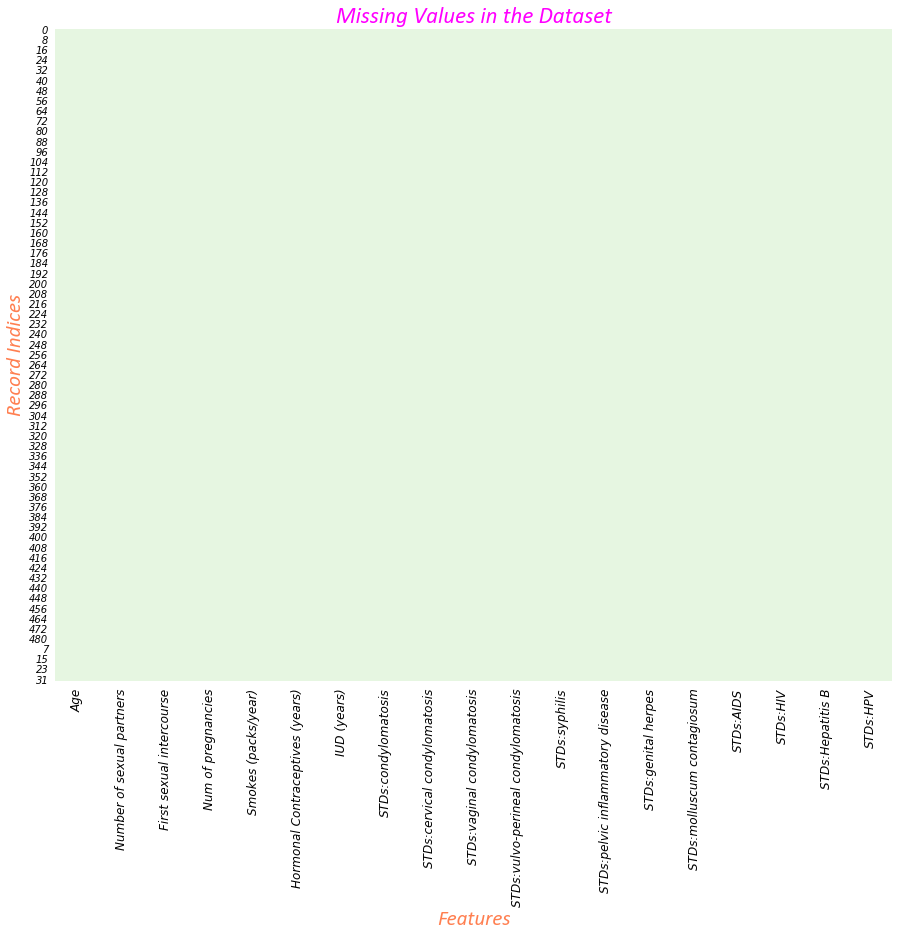

In [66]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,12))
    sns.heatmap(data=pd.DataFrame(new_X1.isnull()),cmap=ListedColormap(sns.color_palette('GnBu',10)),cbar=False)
    plt.xlabel('Features',fontdict=label_dict)
    plt.ylabel('Record Indices',fontdict=label_dict)
    plt.title('Missing Values in the Dataset',fontdict=title_dict)
    plt.xticks(color='black',size=12,style='oblique')
    plt.yticks(color='black',size=10,style='oblique')
plt.show()

In [67]:
new_X1.shape

(514, 19)

In [68]:
y1.shape

(514, 1)

In [75]:
new_X1.reset_index(drop=True,inplace=True)
y1.reset_index(drop=True,inplace=True)

In [76]:
new_X1.index, y1.index

(RangeIndex(start=0, stop=514, step=1), RangeIndex(start=0, stop=514, step=1))

### **`OverSampling Data`**

In [89]:
from imblearn.over_sampling import SMOTE

In [90]:
oversample = SMOTE()

In [91]:
X_os, y_os = oversample.fit_resample(new_X1, y1)

In [147]:
X_os.shape, y_os.shape, y_os.value_counts()

((962, 19),
 (962, 1),
 Biopsy
 1         481
 0         481
 dtype: int64)

In [177]:
def RandomSearchCV(X_train,y_train,clf,param_range,folds):
    """
    Description: This function is created for performing the RandomSearchCV of the classifier hyper-parameter.
    
    Input Parameters: It accepts below parameters:
        1. x_train: np.array
            Input features of shape, (n,d)
        2. y_train: np.array
            Target/Label of shape, (n,) or (n,1)
        3. classifier: its typically KNeighborsClassifier()
        4. param_range: tuple of int values
            Like (a,b) a < b   
            `Note: If a >= b then it will be set as (1,b).`
        5. folds: int
            Represents number of folds we need to devide the data and test our model
            
    Return:
        1. neighbors: list
            Containing values of hyper-parameter
        2. train_acc: list
            Model accuracy score on train data
        3. cv_acc: list
            Model accuracy score on test data
    """
    try:
        param_range[0] >= param_range[1]
    finally:
        param_range = (1, param_range[1])    # "Initialized the lower value of parameter range as 1."
    
    # Calculating the width of a set based on number of Folds and Input dataset size
    # And, generating the range of train and cv sets 
    cv_width = int(np.floor(len(X_train)/folds))
    lowest_val = 0
    max_val = int(len(X_train))
    cv_ranges = []
    for i in range(1,folds+1):
        if i == 1:
            cv_ranges.append((lowest_val, cv_width))
        elif i != folds:
            cv_ranges.append(((cv_width*(i-1)+1), cv_width*(i)))
        elif i == folds:
            cv_ranges.append(((cv_width*(i-1)+1), max_val))
    
    # Dividing the Input dataset into Train & CV sets based on the above calculated ranges
    train_set = []
    cv_set = []
    for i in range(0,folds):
        if i == 0:
            cnt = 1
            cv_set.append(cv_ranges[i])
            train_set.append(cv_ranges[cnt:])
            cnt += 1
        elif i > 0:
            cv_set.append(cv_ranges[i])
            lower_half = cv_ranges[0:i]
            upper_half = cv_ranges[cnt:]
            train_set.append(lower_half + upper_half)
            cnt +=1

    # Running the Classifier for the various values of hyper-parameter on different combinations of Train and CV sets
    k_vals = np.arange(param_range[0],param_range[1])
    neighs = np.sort(np.random.choice(k_vals,size=10,replace=False))
    
    neighbors = []
    train_acc = []
    cv_acc = []
    for k in tqdm(neighs):
        neighbors.append(k)
        taccs = []
        cv_accs = []
        for i in range(len(train_set)):
            X_train_set = np.zeros(shape=(1,X_train.shape[-1]))
            X_cv_set = np.zeros(shape=(1,X_train.shape[-1]))
            y_train_set = np.zeros(shape=(1,1))
            y_cv_set = np.zeros(shape=(1,1))
            for tup in train_set[i]:
                X_train_set = np.r_[X_train_set,X_train[tup[0]:tup[1]+1]]
                y_train_set = np.r_[y_train_set,y_train[tup[0]:tup[1]+1]]
            for indices in [cv_set[i]]:
                X_cv_set = np.r_[X_cv_set,X_train[indices[0]:indices[1]+1]]
                y_cv_set = np.r_[y_cv_set,y_train[indices[0]:indices[1]+1]]

            X_train_set = X_train_set[1:]
            y_train_set = y_train_set[1:]

            X_cv_set = X_cv_set[1:]
            y_cv_set = y_cv_set[1:]
            
            model = clf(n_neighbors=k)
            model.fit(X_train_set,y_train_set)
            taccs.append(model.score(X_train_set,y_train_set))            
            cv_accs.append(model.score(X_cv_set,y_cv_set))
        
        train_acc.append(np.mean(taccs))
        cv_acc.append(np.mean(cv_accs))
        
    return neighbors,train_acc,cv_acc

In [178]:
neighbors, train_accs, cv_accs = RandomSearchCV(np.array(X_os.iloc[:,:]),np.array(y_os.iloc[:,:]),KNeighborsClassifier,(1,19),10)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]c:\users\rajsh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\users\rajsh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\users\rajsh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\users\rajsh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning

In [179]:
print(neighbors, train_accs, cv_accs)

[1, 2, 4, 5, 6, 7, 8, 11, 14, 18] [0.9990759454805163, 0.9763222042745197, 0.9109507535810119, 0.8753758560386602, 0.8778019997597084, 0.8468479087960059, 0.856780760656263, 0.8115050260983327, 0.801916458636479, 0.7724637893978026] [0.8492590206185566, 0.8471649484536081, 0.8253973367697593, 0.7920962199312716, 0.7993878865979381, 0.7754725085910652, 0.7775665807560137, 0.7255906357388315, 0.7203608247422679, 0.6913015463917526]


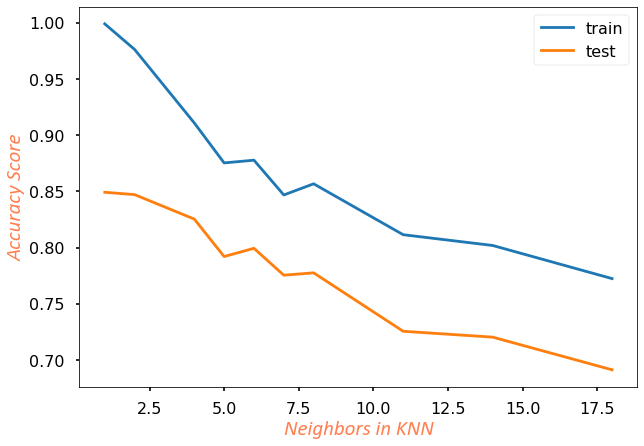

In [180]:
with plt.style.context('seaborn-poster'):
    plt.figure(figsize=(10,7))
    sns.lineplot(x=neighbors,y=train_accs,label='train')
    sns.lineplot(x=neighbors,y=cv_accs,label='test')
    plt.xlabel("Neighbors in KNN",fontdict=label_dict)
    plt.ylabel("Accuracy Score",fontdict=label_dict)

In [182]:
cross_val_score(estimator=KNeighborsClassifier(n_neighbors=7,weights='distance',algorithm='kd_tree'),X=X_os,y=y_os,cv=10,
                n_jobs=-1,scoring='recall').mean()

0.9584183673469386

In [183]:
cross_val_score(estimator=KNeighborsClassifier(n_neighbors=7,weights='distance',algorithm='kd_tree'),X=X_os,y=y_os,cv=10,
                n_jobs=-1,scoring='precision').mean()

0.7450589063167355

In [184]:
# Loading some example data
X_db = np.array(X_os.iloc[:, [2, 4]])
y_db = np.array(y_os['Biopsy'])

# grid cell size
h = .02

x_min, x_max = X_db[:, 0].min() - 1, X_db[:, 0].max() + 1
y_min, y_max = X_db[:, 1].min() - 1, X_db[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

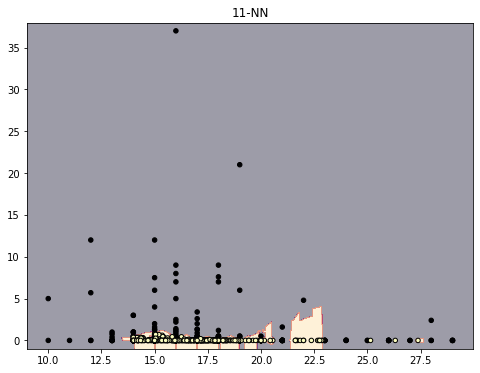

In [185]:
f, axarr = plt.subplots(1,1, figsize=(8, 6))    ## Defining a subplot with 1 row and 1 col 
clf11 = KNeighborsClassifier(n_neighbors=7,weights='distance',algorithm='kd_tree',leaf_size=30)   ## Instantiating the KNN algo
clf11.fit(X_db,y_db)        
Z = clf11.predict(np.c_[xx.ravel(), yy.ravel()])  ## This provide the flattened array for prediction
Z = Z.reshape(xx.shape)
axarr.contourf(xx, yy, Z, alpha=0.4,cmap='magma')  ## This plots the countour from the grid
axarr.scatter(X_db[:, 0], X_db[:, 1], c=y_db,s=20, edgecolor='k',cmap='magma')  ## This creates the scatter plots of data observations
axarr.set_title('{}-NN'.format(11))
plt.show()